In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.linear_model import LinearRegression

#%% Load video
P = './data'
V = 'solidWhiteRight.mp4'
sV = 'Lane_' + V
vc = cv2.VideoCapture(os.path.join(P, V))
fps = vc.get(cv2.CAP_PROP_FPS)
frame_count = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
video = []

In [2]:
#%% Functions
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def lr_lines(x, y):
    Lx, Ly, Rx, Ry = [], [], [], []
    Llimt, Rlimt = vertices[1, 0], vertices[2, 0]

    for xi, yi in zip(x[:,0], y[:,0]):
        if xi < ((Llimt + Rlimt)//2):
            Lx.append(xi)
            Ly.append(yi)
        else:
            Rx.append(xi)
            Ry.append(yi)
    return np.array(Lx), np.array(Ly), np.array(Rx), np.array(Ry)


def linear_reg(x, y, res, Llimt, Rlimt):
    model = LinearRegression(fit_intercept=True)
    model.fit(x[:, np.newaxis], y[:, np.newaxis])
    xfit = np.linspace(Llimt, Rlimt, res)[:, np.newaxis]
    yfit = model.predict(xfit)
    return xfit, yfit

def _line(lines, vertices, res=2500):
    color = [255, 0, 0]
    thickness = 5
    x1 = lines[:, :, 0]
    y1 = lines[:, :, 1]
    x2 = lines[:, :, 2]
    y2 = lines[:, :, 3]
    lines_new = np.zeros((res*2, 1, 4))
    Lx1, Ly1, Rx1, Ry1 = lr_lines(x1, y1)
    Lx2, Ly2, Rx2, Ry2 = lr_lines(x2, y2)
    Lfitx1, Lfity1 = linear_reg(Lx1, Ly1, res, vertices[0, 0], vertices[1, 0])
    Lfitx2, Lfity2 = linear_reg(Lx2, Ly2, res, vertices[0, 0], vertices[1, 0])
    Rfitx1, Rfity1 = linear_reg(Rx1, Ry1, res, vertices[3, 0], vertices[2, 0])
    Rfitx2, Rfity2 = linear_reg(Rx2, Ry2, res, vertices[3, 0], vertices[2, 0])

    nx1 = np.concatenate((Lfitx1, Rfitx1))
    nx2 = np.concatenate((Lfitx2, Rfitx2))
    ny1 = np.concatenate((Lfity1, Rfity1))
    ny2 = np.concatenate((Lfity2, Rfity2))
    
    nx = ((nx1 + nx2)/2).astype(int)
    ny = ((ny1 + ny2)/2).astype(int)

    lines_new = np.concatenate((nx, ny, nx, ny), axis=1)[:, np.newaxis, :]

    return lines_new

(540, 960, 3)


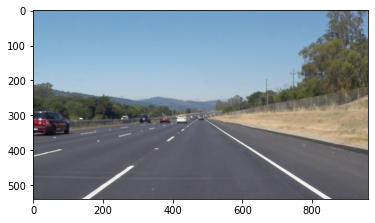

In [3]:
#%% Video process
for idx in range(frame_count):   
    vc.set(1, idx)
    ret, frame = vc.read()
    if idx==25:
        img = frame
        break
    
img = img[:,:,[2,1,0]]
#====================
plt.imshow(img)
print(img.shape)

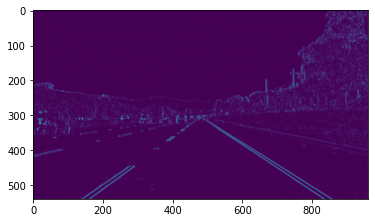

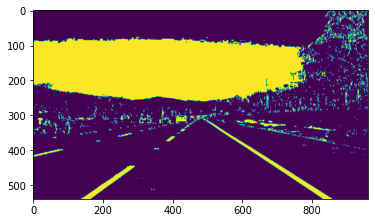

In [4]:
#%% Binary
gray_img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
# Scale result to 0-255
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

sx_binary = np.zeros_like(scaled_sobel)
# Keep only derivative values that are in the margin of interest
sx_binary[(scaled_sobel >= 25) & (scaled_sobel <= 255)] = 1
# Detect pixels that are white in the grayscale image
white_binary = np.zeros_like(gray_img)
white_binary[(gray_img > 180) & (gray_img <= 255)] = 1
# Combine all pixels detected above
binary_warped = cv2.bitwise_or(sx_binary, white_binary)

#====================
fig_0 = plt.figure(0)
plt.imshow(scaled_sobel)
fig_1 = plt.figure(1)
plt.imshow(binary_warped)

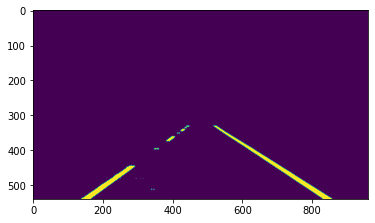

In [5]:
#%% Mask
mask = np.zeros_like(binary_warped)   
vertices = np.array(
    [[0, 540],  # Bottom left
    [425, 330],  # Top left
    [535, 330],  # Top right
    [960, 540]]) # Bottom right
    
#defining a 3 channel or 1 channel color to fill the mask with depending on the input image
if len(binary_warped.shape) > 2:
    channel_count = binary_warped.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255
    
#filling pixels inside the polygon defined by "vertices" with the fill color    
cv2.fillPoly(mask, [vertices], ignore_mask_color)

#returning the image only where mask pixels are nonzero
masked_image = cv2.bitwise_and(binary_warped, mask)

#====================
fig_0 = plt.figure(0)
plt.imshow(masked_image)


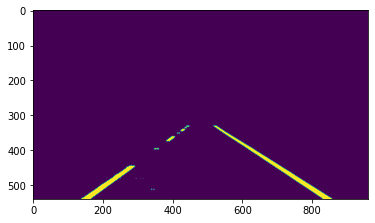

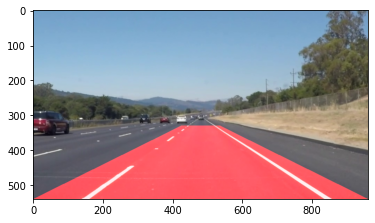

In [6]:
rho = 1
theta = np.pi/180
threshold = 1
min_line_len = 10
max_line_gap = 1

lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
line_img = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
lines_new = _line(lines, vertices)
draw_lines(line_img, lines_new)

#====================
fig_0 = plt.figure(0)
plt.imshow(masked_image)
fig_1 = plt.figure(1)
mask_r = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
mask_r[:,:,0], mask_r[:,:,1], mask_r[:,:,2] = mask, mask*0, mask*0
mask_result = cv2.addWeighted(mask_r, 1, img, 1, 0)
plt.imshow(mask_result)

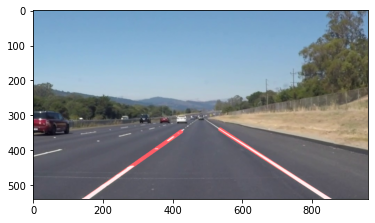

In [7]:
#%% Result
result = cv2.addWeighted(line_img, 1, img, 1, 0)

#====================
fig_0 = plt.figure(0)
plt.imshow(result)
